In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
from TESStools import *
from tqdm.notebook import tqdm

In [2]:
fyps = pd.read_csv('fyps.csv')
this_star = fyps[fyps['CommonName'] == 'HD 269902']
this_star

,CommonName,ContRatio,Dec,Dec_y,MKType,MatchID,RA,RA_y,SimbadOType,SimbadSpT,...,w3mag,w4mag,alpha,e_alpha,tau,e_tau,gamma,e_gamma,alpha_w,e_alpha_w
4,HD 269902,NaN,-69.105921,NaN,A1Ia+,277300045,84.539929,NaN,SG*,A1Ia+,...,9.188,4.947,0.023556,0.000863,0.314467,0.013045,1.73858,0.026115,0.001752,7.700922e-07


In [3]:
#prewhitening
tic = this_star['TIC ID'].iloc[0]
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
good_fs, good_amps, good_phases, good_snrs, good_peaks = prewhiten(time, flux, err)
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
freq, power = LombScargle(time, flux, dy=err).autopower(normalization='psd')
power /= len(time)
popt, pcov, resid = fit_red_noise(freq, power)

Found 5 frequencies
5 unique frequencies


In [4]:
for f,s in zip(good_fs,good_snrs):
    print(f[0],s)

2.903383768236067 62.496899554446465
1.4517133760239014 53.91882512253329
4.355332924428062 56.677329762057234
5.806783636730599 26.09218558547975
0.08168479450896912 5.551759784910595


In [5]:
ls_dict = {0:'--',1:'-.',2:':'}

In [6]:
tall = good_fs[0,0]
undetected = tall/2

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


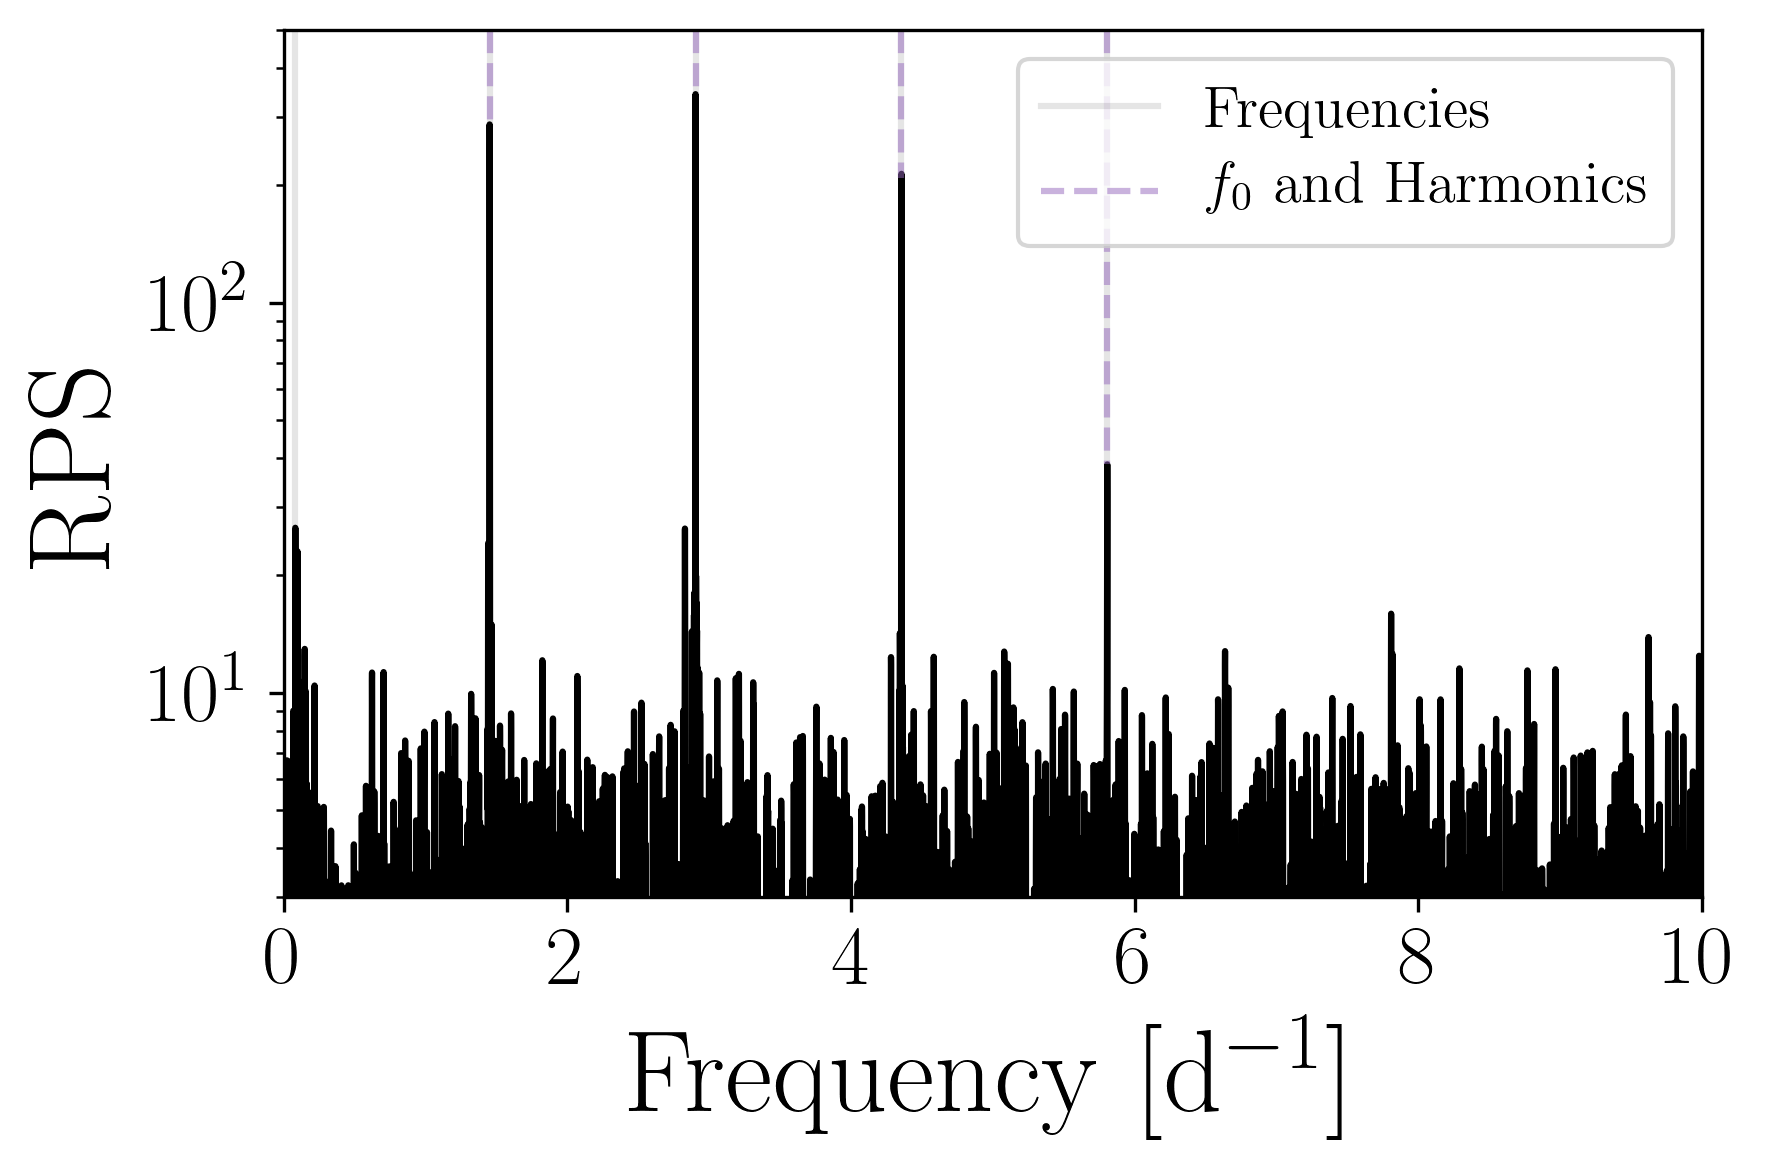

In [11]:
fig = plt.figure(dpi=300)
plt.semilogy(freq, resid,c='k')

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='RPS', xlim=(0,10),ylim=(3,500))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],resid[np.argmin(np.abs(freq-good_fs[0,0]))]],alpha=0.1,c='k',label='Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],resid[np.argmin(np.abs(freq-f))]],c='k',alpha=0.1)

plt.plot([undetected,undetected],[ylim[1],resid[np.argmin(np.abs(freq-undetected))]],c=f'C4',ls='--',alpha=0.5,label = r'$f_0$ and Harmonics')
for i in [2,3,4]:
    plt.plot([undetected*i,undetected*i],[ylim[1],resid[np.argmin(np.abs(freq-undetected*i))]],ls='--',alpha=0.5,c=f'C4')

ax.set_ylim(ylim)
leg = ax.legend(fontsize=14)
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/hd269902_frequencies.pdf')

In [14]:
#WWZ wavelet fun
#Let's put our functions in a list that we can loop over
func_list = [phi_1,phi_2,phi_3]
f1 = phi_1 #we're also going to need this one explicitly later
#and finally a decay constant for the Gaussian envelope
c = 0.0125
y = flux.values
t = time.values
omega_start = -1 #log2(1/32)
omega_end = 5.5 #log2(16) 
omegas = np.logspace(omega_start,omega_end,1000,base=2)
taus = np.linspace(np.min(t),np.max(t),500)
wwz,wwa = MP_WWZ(func_list,f1,y,t,omegas,taus,c=c)

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


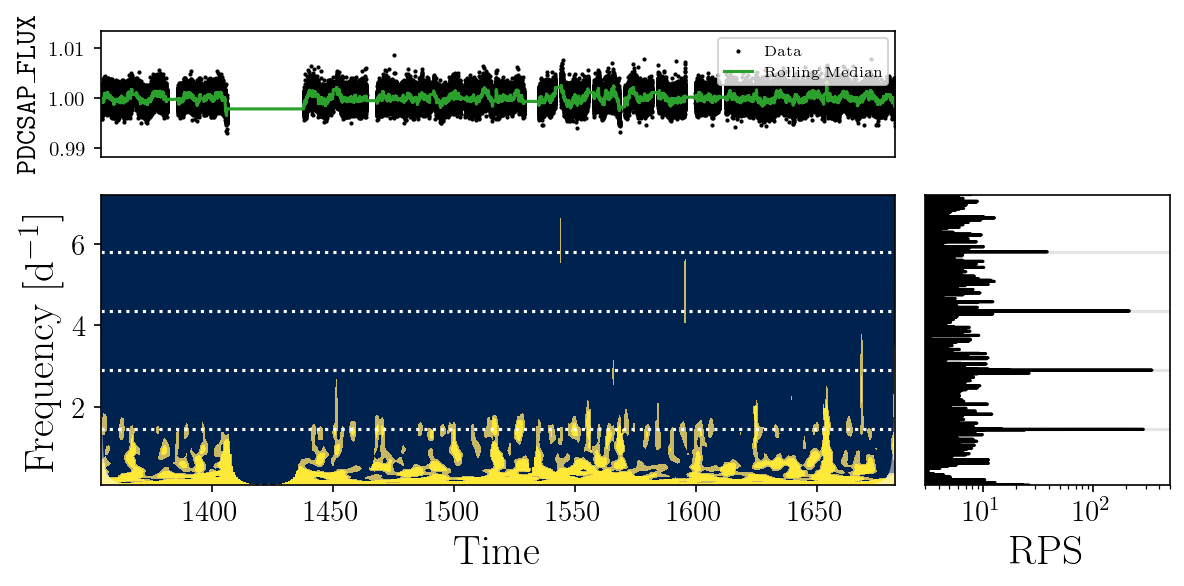

In [15]:
fig = plt.figure(constrained_layout=True,figsize=(8,4),dpi=150)

gs = GridSpec(3, 4, figure=fig)
lcax = fig.add_subplot(gs[0, :3])
wwzax = fig.add_subplot(gs[1:,:3])
zsumax = fig.add_subplot(gs[1:,3])

lcax.scatter(time,flux,s=1,c='k',label=r'Data',rasterized=True)
lcax.plot(lc_smooth['Time'],lc_smooth['Flux'],c='C2',label=r'Rolling Median',rasterized=True)
lcax.set(ylabel=r'$\mathrm{\tt PDCSAP\\\_FLUX}$',xlim=(np.min(time),np.max(time)),xticks=[])
h, l = lcax.get_legend_handles_labels()
lcax.legend(h[::-1],l[::-1],loc='upper right',fontsize='x-small')

wwzax.contourf(taus,omegas/2.0/np.pi,wwz,levels=100,cmap='cividis',vmax=35,vmin=10)
wwzax.fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.set(ylabel=r'Frequency [d$^{-1}$]',xlabel='Time',
          ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)))



zsumax.semilogx(resid,freq,c='k',rasterized=True)
zsumax.set(yticks=[],xlabel=r'RPS',
           ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)),
           xlim=(3,500))
zs_lim = zsumax.get_xlim()
for f in good_fs[:,0]:
    wwzax.axhline(y=f,c='white',ls=':')
    zsumax.plot([zs_lim[1],resid[np.argmin(np.abs(freq-f))]],[f,f],c='k',alpha=0.1)

for ax in [lcax,wwzax,zsumax]:
    if ax == lcax:
        ax.xaxis.label.set_size(14)
        ax.yaxis.label.set_size(14)
    else:
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
    plt.tight_layout()
plt.savefig('../plots/hd269902_wwz.pdf')

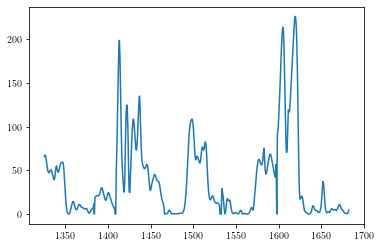

In [31]:
ridge = wwz[np.argmin(np.abs(omegas/2/np.pi - good_fs[0,0])),:]
plt.plot(taus,ridge)
plt.savefig('WOW_time')

0.010362376990261707


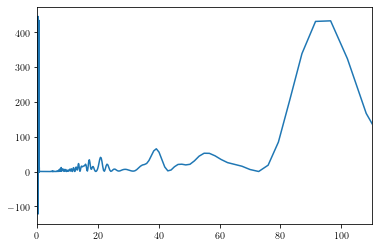

In [39]:
ls_ridge = LombScargle(taus, ridge)
f_ridge, pow_ridge = ls_ridge.autopower(normalization='psd')
pow_ridge /= len(taus)
window = (1.0/f_ridge <= 110) & (1.0/f_ridge >= 40)
plt.plot(1/f_ridge,pow_ridge)
plt.xlim(0,110)
print(f_ridge[window][np.argmax(pow_ridge[window])])
plt.savefig('WOW_power')